In [3]:
import json
import string
import matplotlib.pyplot as plt 
import json_lines
import itertools

with open('result.jl', 'rb') as f:
    
    entities = [x for x in itertools.islice(json_lines.reader(f), 10000)]
    stories = [x for x in entities if str(x['pageType']) == "story"]
    reviews = [x for x in entities if str(x['pageType']) == "review"]
    users = [x for x in entities if str(x['pageType']) == "user"]
    
    print(len(stories),len(reviews),len(users))
    #print(max(stories, key=lambda x: int(str(x['otherInfo']['favorites']).replace(',', ''))))
    #favorites = [int(str(x['otherInfo']['favorites'])) for x in stories]
    
    #print(max(stories, key=lambda x: int(str(x['otherInfo']['words']).replace(',', ''))))

1060 8669 271


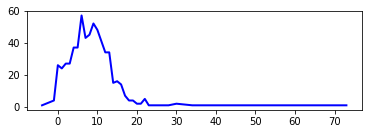

In [4]:
import operator
storyReviewDic = {}
for review in reviews:
    if(review['reviewOf'] not in storyReviewDic):
        storyReviewDic[review['reviewOf']] = []
    storyReviewDic[review['reviewOf']].append(review)

storySentimentScores = [sum([z['sentimentScore'] for z in y]) for x, y in storyReviewDic.items()]

buckets = {}

def updateBucket(x):
    buckets.setdefault(x, 0)
    buckets[x]+=1

[ updateBucket(int(x)) for x in storySentimentScores]

sortedBuckets = sorted(buckets.items(), key=operator.itemgetter(0))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot([x for x,y in sortedBuckets], [y for x,y in sortedBuckets], color='blue', lw=2)

#print(sum(storySentimentScore)/ len(storySentimentScore))

In [5]:
sum(storySentimentScores)/len(storySentimentScores)

8.890580487804884

In [6]:
import numpy as np
idDict = {}
idCnt = 0

for x in users:
    if(x['name'] in idDict):
        continue;
    idDict[idCnt] = x['name']
    idCnt += 1

nameToIdDict = {v: k for k, v in idDict.items()}

userFavorites = {}
for user in users:
    userId = nameToIdDict[user['name']]
    userFavorites[userId] = []
    for favorite in user['favorites']:
        auther = favorite['favAuthor']
        if(auther in nameToIdDict):
            autherId = nameToIdDict[auther]
            if(autherId not in userFavorites[userId]):
                userFavorites[userId].append(autherId)
                
matrix = np.zeros([len(idDict), len(idDict)])

for userId, favorites in userFavorites.items():
    matrix[userId, userId] = 1
    for favId in favorites:
        matrix[userId, favId] = 1

In [12]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

random_state = 345345
pred = KMeans(n_clusters=5, random_state=random_state).fit_predict(matrix)

i = 0
clusters = {}
def makeCombined(x):
    global i
    row = [i,x]
    i += 1
    return row

usersWithCluster = [makeCombined(x) for x in pred]

<Figure size 864x864 with 0 Axes>

In [13]:
import collections

clusters = collections.defaultdict(list)
for x in usersWithCluster:
    clusters[x[1]].append(x[0])
clusters = dict(clusters)
print([len(j) for i,j in clusters.items()])

[20, 15, 215, 2, 19]


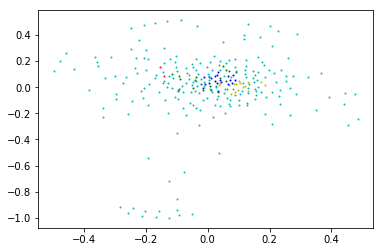

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

colors = ['r', 'b', 'y', 'g', 'c', 'black', 'm', 'orange', 'grey', '']

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    #print([x for x in edges])
    gr = nx.Graph()
    gr.add_edges_from(edges)
    #gr[0][1]['color'] = 'color'
    
    #nx.draw(gr, node_size=1)
    pos=nx.spring_layout(gr) 
    for i in range(5):
        nx.draw_networkx_nodes(gr,pos,nodelist = clusters[i], node_size=1, node_color=colors[i])
    #nx.draw_networkx_nodes(gr,pos,nodelist = clusters[1], node_size=1, node_color=colors[1])
    
    #nx.draw_networkx_edges(gr,pos,
    #                   width=1,alpha=0.5,edge_color='r')
    plt.show()
    
show_graph(matrix)


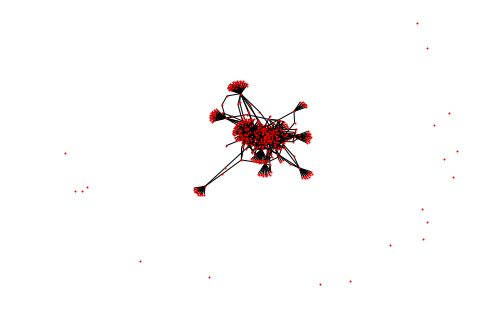

In [135]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    nx.draw(gr, node_size=1)
    plt.show()
    
show_graph(matrix)